In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import torch.optim as optim
#----------------------------------
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

device = "cuda" if torch.cuda.is_available else "cpu"

In [3]:
Lenet = LeNet().to(device)

In [4]:
#load the model

model_path = os.getcwd() +"/lenet_MNIST.pth"
print(model_path)
Lenet = torch.load(model_path, map_location=torch.device('cuda'))


/home/ag8298/Desktop/Summer2023/lenet/lenet_MNIST.pth


In [5]:
summary(Lenet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [6]:
data_test = datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

test_loader = DataLoader(data_test)

/usr/lib/python3/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


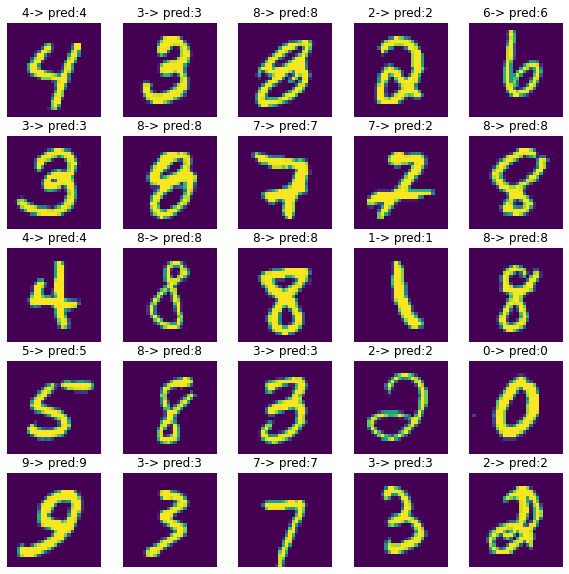

In [7]:
figure = plt.figure(figsize = (10,10))
cols, rows = 5,5
for i in range(1, cols*rows + 1):
    index = torch.randint(len(data_test), size = (1,)).item()
    figure.add_subplot(rows, cols, i)
    img = data_test[index][0]
    label = data_test[index][1]
    #------------------------------
    features = img
    features = features.to(device)
    out = Lenet(features)
    pred = torch.max(out,1)[1]
    #-----------------------------
    plt.title(f"{label}-> pred:{pred.item()}")
    plt.axis("off")
    plt.imshow(img.view(28,28))

    #plt.imshow(img.numpy().squeeze(),cmap="Greys")           # .squeeze() flattens the given tensor or matrix into 1-d array.
plt.show()

### Deep Fool attack


In [8]:
from torchattacks.attacks import deepfool
import torchattacks


In [9]:
#generate deepfool adversarial images
from torch.utils.data import DataLoader, Subset

attack = torchattacks.DeepFool(Lenet)
examples = []
i = 0

# dataset = test_loader.dataset

# subset_indices = list(range(len(dataset)))
# subset_indices.pop(8)
# subset = Subset(dataset, subset_indices)
# #--------
# new_dataloader = DataLoader(subset)



for image, label in test_loader:
    print(i)
    i += 1
    if i != 9 or i != 8:
        image, label = image.to(device), label.to(device)
        adv_images = attack(image, label)
        examples.append((adv_images,label))
    

0
1
2
3
4
5
6
7


IndexError: index 9 is out of bounds for dimension 0 with size 9

In [10]:
print(len(examples))
correct = 0
for each in examples:
    images = each[0]
    label = each[1]
    
    out = Lenet(images)
    pred = torch.max(out,1)[1]
    print(f"the prediction was {pred.item()} while the label was {label.item()}")
    if pred.item() == label.item():
        correct += 1
        
print("the correct answers are", correct)

7
the prediction was 2 while the label was 7
the prediction was 0 while the label was 2
the prediction was 6 while the label was 1
the prediction was 6 while the label was 0
the prediction was 9 while the label was 4
the prediction was 1 while the label was 1
the prediction was 8 while the label was 4
the correct answers are 1


torch.Size([1, 1, 28, 28])


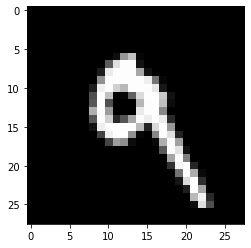

In [11]:
print(image.shape)

img = image.squeeze(0).squeeze(0).to("cpu").numpy()
plt.imshow(img, cmap="gray")

In [12]:
adv_images = adv_images.to("cuda")
out = Lenet(adv_images)
prediction = torch.max(out, 1)[1]
print('the prediction is ',prediction.item())
print(label)

the prediction is  8
tensor([4], device='cuda:0')


torch.Size([28, 28])


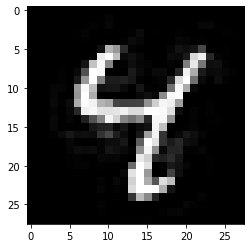

In [13]:
#visualize the adv_image here
adv_images = adv_images.squeeze(0).squeeze(0).to("cpu")
print(adv_images.shape)
plt.imshow(adv_images, cmap="gray")


In [25]:
loss = nn.CrossEntropyLoss()

In [14]:
import torch

def deepfool_attack(model, image, num_classes=10, overshoot=0.02, max_iter=100):
    
    image = image.squeeze(0).to(device)  # Reshape and move image tensor to device
    image.requires_grad = True  # Enable gradient computation for the image

    f_image = model(image)  # Forward pass to get the predicted class probabilities
    _, top_class = torch.max(f_image, 1)  # Get the index of the predicted class
    #target = (top_class.item() + 1) % num_classes  # Choose a target class different from the predicted class

    w = torch.zeros_like(image).to(device)  # Initialize the perturbation vector
    pert_class = None
    
    curr_iter = 0

    while top_class.item() != pert_class or pert_class == None:
    #for _ in range(max_iter):
        pert_image = image + (1 + overshoot) * w  # Perturb the image by adding the perturbation

        f_pert_image = model(pert_image)  # Forward pass with the perturbed image
        _, pert_class = torch.max(f_pert_image, 1)  # Get the index of the predicted class for the perturbed image

        if pert_class.item() != top_class.item():
            break  # Exit the loop if the perturbed image is misclassified as the target class

        # Compute the gradient of the loss with respect to the image
        loss = torch.nn.functional.cross_entropy(f_pert_image, torch.tensor([top_class.item()]).to(device))
        loss.backward()

        # Compute the gradient of the image with respect to the loss
        gradient = image.grad.data

        # Calculate the minimum perturbation required to change the classification
        pert = float('inf')
        for k in range(num_classes):
            if k == top_class.item():
                continue
            w_k = gradient[0, k, ...] - gradient[0, top_class.item(), ...]
            f_k = f_pert_image[0, k]
            f_target = f_pert_image[0, top_class.item()]
            pert_k = abs(f_k - f_target) / torch.norm(w_k)
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # Update the perturbation vector with the minimum perturbation
        w_norm = torch.norm(w)
        w = (1.0 + overshoot) * w / w_norm

        # Reset the gradient for the image
        image.grad.zero_()
        
        if max_iter < curr_iter:
            break
        curr_iter += 1

    adv_image = image + w  # Compute the adversarial image by adding the final perturbation
    adv_image = torch.clamp(adv_image, 0, 1)  # Clamp the pixel values to the valid range

    return adv_image.squeeze(0)  # Remove the batch dimension and return the adversarial image


In [15]:
adv_images = []
for image, label in test_loader:
    image, label = image.to(device), label.to(device)
    pert_img = deepfool_attack(Lenet, image)
    adv_images.append((pert_img,label))
    

/usr/lib/python3/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


the acutal label is  5
the prediction is  6


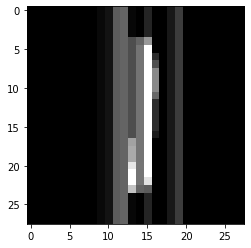

In [16]:
import random

value = random.randint(0, len(test_loader))
img = adv_images[value][0].to("cpu").detach().numpy()
plt.imshow(img, cmap ="gray")
print("the acutal label is ", adv_images[45][1].item())

#------------
pred = Lenet(image.squeeze(0))
out = torch.max(pred, 1)[1]
print("the prediction is ", out.item())

In [17]:

#test the accuracy of the model on adversarial data.
correct = 0
for each in adv_images:
    image, label = each[0].to(device), each[1].to(device)
    out = Lenet(image.unsqueeze(0))
    pred = torch.max(out,1)[1]
    
    if label.item() == pred.item():
        correct += 1
        
print(f"correct: {correct}, accuracy = {correct} / {len(test_loader)} = {correct/float(len(test_loader))} ")


correct: 9487, accuracy = 9487 / 10000 = 0.9487 


<class 'torch.Tensor'>
torch.Size([28, 28])
the prediction is  tensor([6], device='cuda:0')


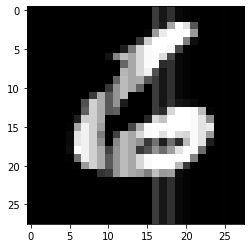

In [18]:
print(type(image))
print(image.shape)

img = image.to("cpu").detach().numpy()
plt.imshow(img, cmap="gray")

pred = Lenet(image.unsqueeze(0))
out = torch.max(pred,1)[1]
print("the prediction is ", out)

In [19]:
image = image.to("cuda").unsqueeze(0).unsqueeze(0)
out = Lenet(image)
pred = torch.max(out,1)[1]
print("the prediction is ",pred.item())

the prediction is  6
